In [ ]:
import sqlite3, os
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
pathname = "/Users/ayemaq/Desktop/MOD3_Project/data/themepark.db"
connection = sqlite3.connect(pathname)

In [ ]:
FIG_DIR = "figures"
os.makedirs(FIG_DIR, exist_ok=True)

# First Visual 
* Daily performance — visits by day (Ops staffing)
* Sunday is the top‑revenue day while Monday is the busiest by visits; staff F&B/merch more on Sundays and ride ops on Mondays.

In [ ]:
daily_sql = """
WITH daily AS (
  SELECT
    dd.date_iso,
    dd.day_name,
    COUNT(DISTINCT fv.visit_id)            AS daily_visits,
    SUM(COALESCE(fv.spend_cents_clean,0))  AS daily_spend_cents
  FROM fact_visits fv
  LEFT JOIN dim_date dd ON dd.date_id = fv.date_id
  GROUP BY dd.date_iso, dd.day_name
)
SELECT date_iso, day_name, daily_visits, daily_spend_cents
FROM daily
ORDER BY date_iso;
"""
daily = pd.read_sql_query(daily_sql, connection)


FileNotFoundError: [Errno 2] No such file or directory: '/Users/ayemaq/Desktop/MOD3_Project/notebooks/figures/daily_visits_highlighted.png'

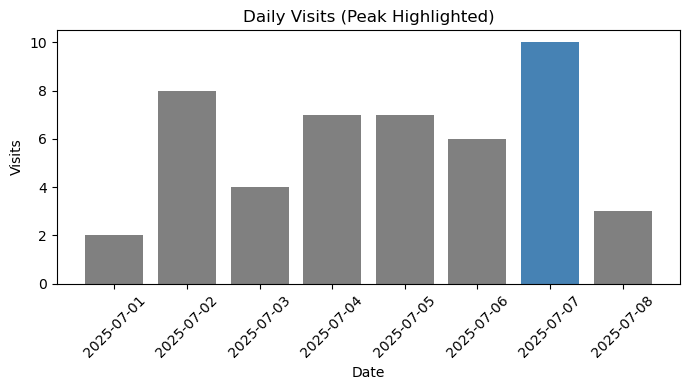

In [31]:
plt.figure(figsize=(7,4))

# find the index of peak
peak_idx = daily["daily_visits"].idxmax()

# loop through bars and color each of them
colors = ["grey" if i != peak_idx else "steelblue" for i in range(len(daily))]

plt.bar(daily["date_iso"], daily["daily_visits"], color=colors)

plt.title("Daily Visits (Peak Highlighted)")
plt.xlabel("Date")
plt.ylabel("Visits")
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig("figures/daily_visits_highlighted.png", bbox_inches="tight")
plt.show()


# Second visual
* CLV (RFM “Monetary”) by state — who’s most valuable (GM/Marketing)
* Top CLV states identify where to concentrate loyalty perks and premium campaigns

In [16]:
clv_state_sql = """
SELECT dg.home_state,
       SUM(COALESCE(fv.spend_cents_clean,0)) AS clv_cents
FROM dim_guest dg
LEFT JOIN fact_visits fv ON fv.guest_id = dg.guest_id
GROUP BY dg.home_state
ORDER BY clv_cents DESC;
"""
clv_state = pd.read_sql_query(clv_state_sql, connection)

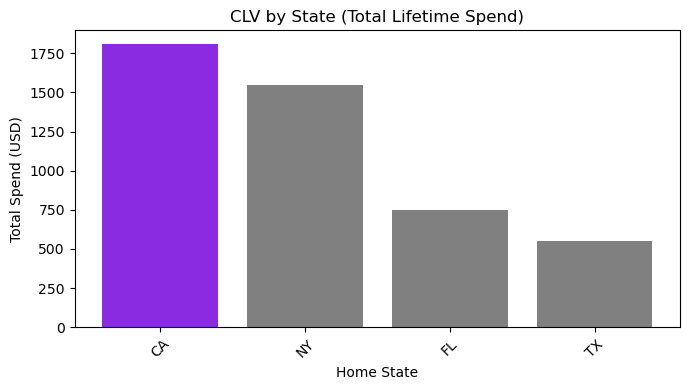

In [17]:
plt.figure(figsize=(7,4))

# find the peak state by CLV
peak_idx = clv_state["clv_cents"].idxmax()

# assign colors: blue for the peak, grey for the rest
colors = ["blueviolet" if i == peak_idx else "grey" for i in range(len(clv_state))]

# plot bar chart
plt.bar(clv_state["home_state"], clv_state["clv_cents"]/100.0, color=colors)

plt.title("CLV by State (Total Lifetime Spend)")
plt.xlabel("Home State")
plt.ylabel("Total Spend (USD)")
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig("figures/clv_by_state.png", bbox_inches="tight")
plt.show()


# Third Visual 
* Behavior change — share of visits that increased spend by ticket type (Marketing)
* Which ticket cohorts are most likely to increase spend on return — target those for step‑up bundles.

In [20]:
lag_share_sql = """
WITH lagged AS (
  SELECT
    fv.guest_id,
    fv.visit_date,
    fv.spend_cents_clean AS curr_spend,
    LAG(fv.spend_cents_clean) OVER (
      PARTITION BY fv.guest_id ORDER BY fv.visit_date
    ) AS prev_spend,
    dt.ticket_type_name
  FROM fact_visits fv
  LEFT JOIN dim_ticket dt USING (ticket_type_id)
)
SELECT
  ticket_type_name,
  SUM(CASE WHEN prev_spend IS NOT NULL THEN 1 ELSE 0 END)              AS comparable_visits,
  SUM(CASE WHEN prev_spend IS NOT NULL AND (curr_spend - prev_spend) > 0 THEN 1 ELSE 0 END) AS increased_visits,
  100.0 * SUM(CASE WHEN prev_spend IS NOT NULL AND (curr_spend - prev_spend) > 0 THEN 1 ELSE 0 END)
        / NULLIF(SUM(CASE WHEN prev_spend IS NOT NULL THEN 1 ELSE 0 END), 0)                AS share_increased_pct
FROM lagged
GROUP BY ticket_type_name
ORDER BY share_increased_pct DESC;
"""
lag_share = pd.read_sql_query(lag_share_sql, connection)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/ayemaq/Desktop/MOD3_Project/notebooks/figures/share_increase_by_ticket.png'

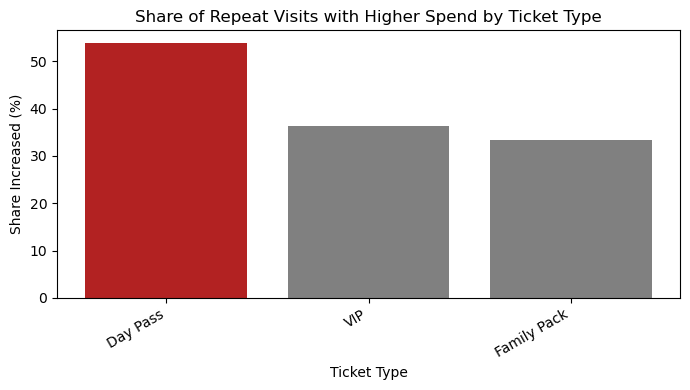

In [30]:
plt.figure(figsize=(7,4))

# find the index of the peak ticket type by share increase
peak_idx = lag_share["share_increased_pct"].idxmax()

# assign colors: highlight the peak, grey out others
colors = ["firebrick" if i == peak_idx else "grey" for i in range(len(lag_share))]

plt.bar(lag_share["ticket_type_name"], lag_share["share_increased_pct"], color=colors)

plt.title("Share of Repeat Visits with Higher Spend by Ticket Type")
plt.xlabel("Ticket Type")
plt.ylabel("Share Increased (%)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()

plt.savefig("figures/share_increase_by_ticket.png", bbox_inches="tight")
plt.show()
